<br/>
  <FONT size ="3pt"> MODAL APM41M01 : Problem solving en math app </FONT>   
  
---
---
<FONT size ="5pt"> TP déterministe 3 : <center><b>Génération de maillage</b>  </center></FONT>

---
---
<br />

In [22]:
# importation de fonctions et de librairies
import numpy as np
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt

from tqdm import tqdm # Pour la barre de progression


De nombreux algorithmes de simulation (tels que la méthode des éléments finis) nécessitent l'utilisation d'un maillage en triangles du domaine de calcul. Le but de ce TP est de construire des maillages aussi réguliers que possible de domaines (presque) quelconques. On commence par introduire la définition d'un maillage.


***
**Définition: Maillage d'un ouvert connexe polyhédrique $\Omega \subset \mathbb R^2$**

Un maillage triangulaire, ou une triangulation de $\Omega$, est un ensemble de $n$ triangles $(K_i)_{i\in 1 \leq i \leq N}$ qui vérifient
* $K_i \subset Ω$ et $Ω = \bigcup\limits_{1 \leq i \leq N} K_i$,
* l’intersection $K_i \cap K_j$ de deux triangles est soit vide, soit réduite à un sommet commun, soit à une arête commune entière.

Les sommets ou noeuds du maillage sont les sommets des triangles $K_i$ qui le composent.
***

On se donnera dans toute la suite une fonction $f(x,y)$ pour laquelle le domaine $\Omega$ à mailler est

$$ \Omega = f^{-1}(\mathbb{R}^-).$$

# Génération de maillage
Dans cette partie, on écrit le mailleur à proprement parler.

## Nuage de points dans la boîte englobante

Une boîte englobante de $\Omega$ est un rectangle $B = ]x_0,x_1[ \times ]y_0, y_1 [$ contenant $\Omega$. On suppose qu'une boîte englobante de notre domaine est donnée. On cherche d'abord à construire un maillage en triangles le plus régulier possible de la boîte englobante $\mathcal{B}$. On choisit un maillage composé de triangles équilatéraux de taille $h$ (pas du maillage).

 Construire une fonction prenant en argument les coordonnées de la boîte englobante et le pas du maillage $h$ et qui renvoie une matrice de coordonnées $N\times 2$ des points d'un maillage triangulaire de $\mathcal{B}$, ou d'une boîte englobante de $\mathcal{B}$ si les dimensions de $\mathcal{B}$ ne sont pas proportionnelles à la hauteur ou la largeur d'un triangle. Les points extérieurs à $\mathcal{B}$ seront éliminés dans une prochaine étape.
 On remarquera que les points ne sont pas espacés de la même manière dans la direction $x$ et $y$ (typiquement ils
diffèrent d'un coefficient $\sqrt{3}/2$).

In [23]:
def maillage_initial(xB, yB, h):
    """
    Créé les points du maillage initial
    ----------
    Paramètres :
    xB = ]x0, x1[, yB = ]y0, y1[ : coordonnées de la boite englobante
    h                            : pas de maillage

    Retourne :
    - vecteur contenant les positions des points du maillage
    """
    hy = h * np.sqrt(3) / 2
    y_B = yB[1] - yB[0]
    ny = round(y_B / hy)

    # On génère ici les lignes de base (2 lignes) qui seront juste translées vers le haut pour avoir le maillage
    x_base1 = np.arange(xB[0], xB[1]+h/2, h, dtype=float)
    x_base1 = np.column_stack((x_base1, np.full_like(x_base1, yB[0]))) # 1ère ligne
    x_base2 = np.arange(xB[0]+h/2, xB[1]+h/4, h, dtype=float)
    x_base2 = np.column_stack((x_base2, np.full_like(x_base2, yB[0] + hy))) # 2ème ligne
    x_base = np.vstack((x_base1, x_base2)) # Motif de la boite englobante ; il faudra éventuellement ajouter encore une ligne de x_base1 tout en haut suivant la parité de ny

    if ny & 1:
        ny_iter = ny // 2 + 1  # Nbre de repétitions du motif
        nber_points = ny_iter * len(x_base)
    else:
        ny_iter = ny // 2
        nber_points = ny_iter * len(x_base) + len(x_base1)

    # Construction du maillage
    grid = np.empty((nber_points, 2))
    for i in range(ny_iter):
        grid[i*len(x_base): (i+1)*len(x_base)] = x_base
        x_base[:, 1] += 2 * hy # On translée le motif vers le haut pour l'iteration suivante

    if not ny & 1:
        # On ajoute les lignes de base1 tout en haut pour compléter le maillage
        x_base1[:, 1] += 2 * (i+1) * hy
        grid[-len(x_base1):] = x_base1
        # grid = np.vstack((grid, x_base1))

    return grid

hy =  0.25980762113533157
xB =  [1.  5.8]
yB =  [1.         4.89711432]
[[1.         1.        ]
 [1.3        1.        ]
 [1.6        1.        ]
 [1.9        1.        ]
 [2.2        1.        ]
 [2.5        1.        ]
 [2.8        1.        ]
 [3.1        1.        ]
 [3.4        1.        ]
 [3.7        1.        ]
 [4.         1.        ]
 [4.3        1.        ]
 [4.6        1.        ]
 [4.9        1.        ]
 [5.2        1.        ]
 [5.5        1.        ]
 [5.8        1.        ]
 [1.15       1.25980762]
 [1.45       1.25980762]
 [1.75       1.25980762]
 [2.05       1.25980762]
 [2.35       1.25980762]
 [2.65       1.25980762]
 [2.95       1.25980762]
 [3.25       1.25980762]
 [3.55       1.25980762]
 [3.85       1.25980762]
 [4.15       1.25980762]
 [4.45       1.25980762]
 [4.75       1.25980762]
 [5.05       1.25980762]
 [5.35       1.25980762]
 [5.65       1.25980762]
 [1.         1.51961524]
 [1.3        1.51961524]
 [1.6        1.51961524]
 [1.9        1.51961524]
 [2

(np.float64(0.76),
 np.float64(6.040000000000001),
 np.float64(0.8051442841485011),
 np.float64(5.0919700328814725))

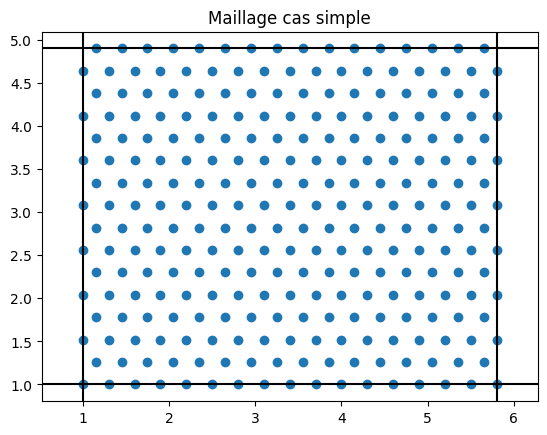

In [24]:
# cas test simple
h = 0.3
hy = h * np.sqrt(3) / 2
print("hy = ", hy)

xB = 1 + np.array([0,  16*h])
yB = 1 + np.array([0, 15*hy])
print("xB = ", xB)
print("yB = ", yB)

grid = maillage_initial(xB, yB, h)
print(grid)

plt.plot(grid[:, 0], grid[:, 1], 'o')
plt.axhline(y=yB[0], color='k')
plt.axhline(y=yB[1], color='k')
plt.axvline(x=xB[0], color='k')
plt.axvline(x=xB[1], color='k')
plt.title("Maillage cas simple")
plt.axis('equal')

xB2 =  [1.  5.3]
yB2 =  [1.         5.19711432]
[[1.         1.        ]
 [1.3        1.        ]
 [1.6        1.        ]
 [1.9        1.        ]
 [2.2        1.        ]
 [2.5        1.        ]
 [2.8        1.        ]
 [3.1        1.        ]
 [3.4        1.        ]
 [3.7        1.        ]
 [4.         1.        ]
 [4.3        1.        ]
 [4.6        1.        ]
 [4.9        1.        ]
 [5.2        1.        ]
 [1.15       1.25980762]
 [1.45       1.25980762]
 [1.75       1.25980762]
 [2.05       1.25980762]
 [2.35       1.25980762]
 [2.65       1.25980762]
 [2.95       1.25980762]
 [3.25       1.25980762]
 [3.55       1.25980762]
 [3.85       1.25980762]
 [4.15       1.25980762]
 [4.45       1.25980762]
 [4.75       1.25980762]
 [5.05       1.25980762]
 [5.35       1.25980762]
 [1.         1.51961524]
 [1.3        1.51961524]
 [1.6        1.51961524]
 [1.9        1.51961524]
 [2.2        1.51961524]
 [2.5        1.51961524]
 [2.8        1.51961524]
 [3.1        1.51961524]
 [

(np.float64(0.7699999999999999),
 np.float64(5.829999999999998),
 np.float64(0.7901442841485014),
 np.float64(5.406970032881473))

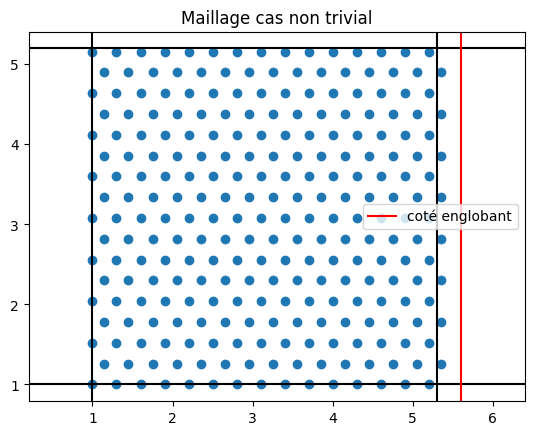

In [25]:
# cas test
xB2 = xB +np.array([0, -0.5])
yB2 = yB + np.array([0, 0.3])
print("xB2 = ", xB2)
print("yB2 = ", yB2)

grid2 = maillage_initial(xB2, yB2, h)
print(grid2)

plt.plot(grid2[:, 0], grid2[:, 1], 'o')
plt.axhline(y=yB2[0], color='k')
plt.axhline(y=yB2[1], color='k')
plt.axvline(x=xB2[0], color='k')
plt.axvline(x=xB2[1], color='k')

plt.axvline(x=xB2[1]+h, color='r', label="coté englobant")

plt.legend()
plt.title("Maillage cas non trivial")
plt.axis('equal')

## Triangulation de Delaunay et création d'un maillage

***
**Définition**: Etant donné un nuage de points $\mathcal S$ (c'est-à-dire un ensemble fini de points dans $\mathbb R^2$), on note $\Omega$ son enveloppe convexe. Une triangulation de $\mathcal S$ est un maillage de $\Omega$ dont les sommets sont les points de $\mathcal S$.
***



***
**Définition**: Etant donné un nuage de points, une triangulation de ce nuage de points est dite *de Delaunay* si les cercles circonscrits (ouverts) aux triangles ne contiennent aucun des points du nuage.
***



Les triangulations de Delaunay maximisent le plus petit angle de l'ensemble des angles des triangles, évitant ainsi les triangles *allongés*. On peut montrer (mais ce n'est pas le but du TP) que pour un nuage de points donné qui ne possède pas 4
points cocycliques ni trois points alignés, il existe une unique triangulation de Delaunay possédant ces points
comme sommets.

1. Prendre un nuage de six points au hasard, générer sa triangulation de Delaunay et afficher le tout. On
utilisera la commande *scipy.spatial.Delaunay*.

Text(0.5, 1.0, 'Triangulation de Delaunay pour 6 points aléatoires')

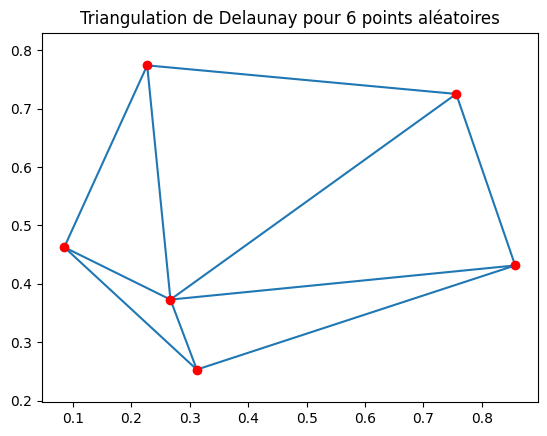

In [26]:
# test simple de la fonction Delaunay et tracé d'une triangulation
points = np.random.rand(6, 2)

tri = Delaunay(points)

plt.triplot(points[:, 0], points[:, 1], tri.simplices)
plt.plot(points[:, 0], points[:, 1], "ro")
plt.axis("equal")
plt.title("Triangulation de Delaunay pour 6 points aléatoires")

2. Utiliser les points obtenus à la partie précedente pour créer un maillage de la boite englobante (ou d'un domaine un peu plus grand) :
    * Construire des triangles avec ces points avec la commande *scipy.spatial.Delaunay*.
    * Tracer le maillage obtenu grâce à la commande *matplotlib.pyplot.triplot*.

Text(0.5, 1.0, 'Triangulation de Delaunay avec les points obtenus à la partie précédente')

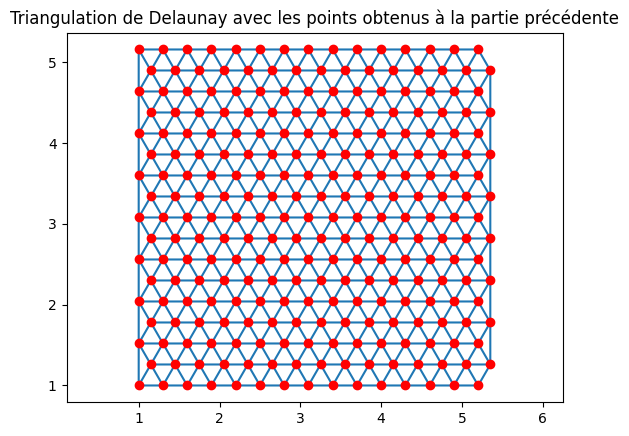

In [27]:
# Cas test : boite englobante
tri_prev = Delaunay(grid2)
plt.triplot(grid2[:, 0], grid2[:, 1], tri_prev.simplices)
plt.plot(grid2[:, 0], grid2[:, 1], "ro")
plt.axis("equal")
plt.title("Triangulation de Delaunay avec les points obtenus à la partie précédente")

3. Parmi les points précédents, ne garder que ceux qui correspondent à $f(X) < 0$. On propose ci-dessous une fonction $f$ (sous le nom *f_domaine*) que vous pouvez changer.

[[2.8        1.51961524]
 [3.1        1.51961524]
 [2.35       1.77942286]
 [2.65       1.77942286]
 [2.95       1.77942286]
 [3.25       1.77942286]
 [3.55       1.77942286]
 [3.85       1.77942286]
 [1.9        2.03923048]
 [2.2        2.03923048]
 [2.5        2.03923048]
 [2.8        2.03923048]
 [3.1        2.03923048]
 [3.4        2.03923048]
 [3.7        2.03923048]
 [4.         2.03923048]
 [1.75       2.29903811]
 [2.05       2.29903811]
 [2.35       2.29903811]
 [2.65       2.29903811]
 [2.95       2.29903811]
 [3.25       2.29903811]
 [3.55       2.29903811]
 [3.85       2.29903811]
 [4.15       2.29903811]
 [1.6        2.55884573]
 [1.9        2.55884573]
 [2.2        2.55884573]
 [2.5        2.55884573]
 [2.8        2.55884573]
 [3.1        2.55884573]
 [3.4        2.55884573]
 [3.7        2.55884573]
 [4.         2.55884573]
 [4.3        2.55884573]
 [1.75       2.81865335]
 [2.05       2.81865335]
 [2.35       2.81865335]
 [2.65       2.81865335]
 [2.95       2.81865335]


(np.float64(1.350048820505603),
 np.float64(4.649997675214019),
 np.float64(1.3500127863724387),
 np.float64(4.649987213627561))

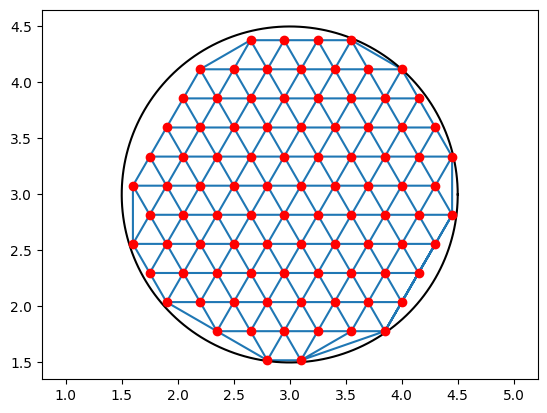

In [28]:
# Cas test : boite englobante sans les points en dehors de Omega
x0, y0, r = 3, 3, 1.5
f = lambda X: np.sum((X - np.array([x0, y0])) ** 2, axis=1) - r**2

# Tracé du cercle (boite englobante)
theta = np.linspace(0, 2*np.pi, 400)
x = x0 + r*np.cos(theta)
y = y0 + r*np.sin(theta)
plt.plot(x, y, 'k')

# print(f(grid2))
mask = f(grid2) < 0
grid_filter = grid2[mask]
print(grid_filter)

tri_prev = Delaunay(grid_filter)
plt.plot(grid_filter[:, 0], grid_filter[:, 1], "ro")
plt.triplot(grid_filter[:, 0], grid_filter[:, 1], tri_prev.simplices)
plt.axis("equal")

# Modification du maillage
Les arrêtes du maillage précedemment construit ne coïncident pas en général avec le bord du domaine $\Omega$. C'est ce que nous proposons d'adapter à présent.
L'idée que nous allons utiliser est d'assimiler le maillage à un assemblage de ressorts. L'astuce consiste
à calculer une longueur idéale pour les ressorts et d'essayer d'agrandir ceux qui sont trop courts afin de remplir le domaine avec les triangles les plus réguliers possibles.

## Les arêtes du maillage

1. Fabriquer un tableau qui contient pour chaque arête l'indice de ses deux sommets. On se servira du tableau des triangles (*Delaunay(points).simplices*) et on en extraira les arêtes. Attention, il faudra sans doute supprimer les doublons.

2. Construire un tableau des vecteurs directeurs normalisés des arêtes, orientés du sommet 1 au sommet 2 de chacune des arêtes, ainsi que le tableau des longueurs $L[i]$ de ces vecteurs.

3. Calculer la longueur idéale $L_0 = 1.2 \sqrt{\sum\limits_i L[i]^2 /N}$, le paramètre $1.2$ servira à faire "augmenter" les longueurs des arêtes.

4. Construire un tableau de "forces" orientées le long des arêtes et de module $max(L_0 − L[i], 0)$ (on ne bougera pas les longueurs dejà plus grandes que $L_0$).

In [29]:
# Construction des tableaux d'arêtes, de vecteurs directeurs, de forces...
# 1/
simplices = tri_prev.simplices
# On considère tous les couples de sommets pour avoir les aretes
edges = np.vstack([simplices[:, [0, 1]], simplices[:, [1, 2]], simplices[:, [2, 0]]])
edges = np.sort(edges, axis=1) # On trie suivant l'ordre des sommets pour pouvoir aisément supprimer les doublons par la suite
edges = np.unique(edges, axis=0) # On supprime les doublons
print(edges)

[[ 0  1]
 [ 0  2]
 [ 0  3]
 [ 0  4]
 [ 1  4]
 [ 1  5]
 [ 1  6]
 [ 1  7]
 [ 2  3]
 [ 2  8]
 [ 2  9]
 [ 2 10]
 [ 3  4]
 [ 3 10]
 [ 3 11]
 [ 4  5]
 [ 4 11]
 [ 4 12]
 [ 5  6]
 [ 5 12]
 [ 5 13]
 [ 6  7]
 [ 6 13]
 [ 6 14]
 [ 7 14]
 [ 7 15]
 [ 7 34]
 [ 7 44]
 [ 8  9]
 [ 8 16]
 [ 8 17]
 [ 9 10]
 [ 9 17]
 [ 9 18]
 [10 11]
 [10 18]
 [10 19]
 [11 12]
 [11 19]
 [11 20]
 [12 13]
 [12 20]
 [12 21]
 [13 14]
 [13 21]
 [13 22]
 [14 15]
 [14 22]
 [14 23]
 [15 23]
 [15 24]
 [15 34]
 [16 17]
 [16 25]
 [16 26]
 [17 18]
 [17 26]
 [17 27]
 [18 19]
 [18 27]
 [18 28]
 [19 20]
 [19 28]
 [19 29]
 [20 21]
 [20 29]
 [20 30]
 [21 22]
 [21 30]
 [21 31]
 [22 23]
 [22 31]
 [22 32]
 [23 24]
 [23 32]
 [23 33]
 [24 33]
 [24 34]
 [25 26]
 [25 35]
 [25 45]
 [26 27]
 [26 35]
 [26 36]
 [27 28]
 [27 36]
 [27 37]
 [28 29]
 [28 37]
 [28 38]
 [29 30]
 [29 38]
 [29 39]
 [30 31]
 [30 39]
 [30 40]
 [31 32]
 [31 40]
 [31 41]
 [32 33]
 [32 41]
 [32 42]
 [33 34]
 [33 42]
 [33 43]
 [34 43]
 [34 44]
 [35 36]
 [35 45]
 [35 46]
 [36 37]
 

In [30]:
# 2/
vects = grid_filter[edges[:, 1]] - grid_filter[edges[:, 0]]
# print(vects)
L = np.linalg.norm(vects, axis=1)
print("L = ", L)
vects_norm = vects / L[:, None]
print(vects_norm)

L =  [0.3        0.51961524 0.3        0.3        0.3        0.3
 0.51961524 0.79372539 0.3        0.51961524 0.3        0.3
 0.3        0.3        0.3        0.3        0.3        0.3
 0.3        0.3        0.3        0.3        0.3        0.3
 0.3        0.3        0.9        1.2        0.3        0.3
 0.3        0.3        0.3        0.3        0.3        0.3
 0.3        0.3        0.3        0.3        0.3        0.3
 0.3        0.3        0.3        0.3        0.3        0.3
 0.3        0.3        0.3        0.6        0.3        0.3
 0.3        0.3        0.3        0.3        0.3        0.3
 0.3        0.3        0.3        0.3        0.3        0.3
 0.3        0.3        0.3        0.3        0.3        0.3
 0.3        0.3        0.3        0.3        0.3        0.3
 0.3        0.3        0.51961524 0.3        0.3        0.3
 0.3        0.3        0.3        0.3        0.3        0.3
 0.3        0.3        0.3        0.3        0.3        0.3
 0.3        0.3        0.3        0

In [31]:
# 3/
L0 = 1.2 * np.sqrt(np.mean(L**2))
print(L0)

0.3911250740228907


In [32]:
# 4/
forces_intensities = np.maximum(L0-L, 0.0)
print(forces_intensities)

[0.09112507 0.         0.09112507 0.09112507 0.09112507 0.09112507
 0.         0.         0.09112507 0.         0.09112507 0.09112507
 0.09112507 0.09112507 0.09112507 0.09112507 0.09112507 0.09112507
 0.09112507 0.09112507 0.09112507 0.09112507 0.09112507 0.09112507
 0.09112507 0.09112507 0.         0.         0.09112507 0.09112507
 0.09112507 0.09112507 0.09112507 0.09112507 0.09112507 0.09112507
 0.09112507 0.09112507 0.09112507 0.09112507 0.09112507 0.09112507
 0.09112507 0.09112507 0.09112507 0.09112507 0.09112507 0.09112507
 0.09112507 0.09112507 0.09112507 0.         0.09112507 0.09112507
 0.09112507 0.09112507 0.09112507 0.09112507 0.09112507 0.09112507
 0.09112507 0.09112507 0.09112507 0.09112507 0.09112507 0.09112507
 0.09112507 0.09112507 0.09112507 0.09112507 0.09112507 0.09112507
 0.09112507 0.09112507 0.09112507 0.09112507 0.09112507 0.09112507
 0.09112507 0.09112507 0.         0.09112507 0.09112507 0.09112507
 0.09112507 0.09112507 0.09112507 0.09112507 0.09112507 0.0911

## Algorithme de Newton : Projection sur le bord

Après une étape de déplacement des points, certains d'entre eux peuvent se retrouver en dehors du domaine. On va donc reprojeter ces points sur le bord du domaine.  

Pour ce faire, on se donne une fonction $f$ (suffisament régulière) dont l'isovaleur $f(X) = 0$ décrit le bord
du domaine de calcul. On cherchera à projeter des points proches du bord orthogonalement sur le bord. On utilise pour cela une méthode de type Newton : étant donné un point $X_0$ à projeter, on définit la fonction $g(\lambda)$ par

$$g(\lambda) = f\left(X_0 + \lambda \nabla f(X_0)\right),$$

et on construit une suite $\lambda_k$ qui converge vers $\lambda_*$ tel que $g(\lambda_*) = 0$. Plus précisément, on applique l'algorithme :

$$\lambda_0 = 0 \quad \text{ et } \quad \lambda_{k+1} = \lambda_k - \frac{g(\lambda_k)}{g'(\lambda_k)} \quad \text{ jusqu'à convergence.}$$

Implémenter une fonction *Newton* qui prend comme argument (entre autre) la fonction $f$ et renvoie le coefficient $\lambda$ calculé par cette méthode. Le point projeté est $X_0 +  \lambda \nabla f(X_0)$.  Tester la méthode sur des cas pratiques.

*Indications :* Pour le calcul de $\nabla f(X)$ on pourra (par exemple) :
- Soit passer la fonction qui calcule aussi $\nabla f$ en paramètre si on la connait analytiquement.
- Soit calculer $\nabla f(X)$ en l'approchant par différences finies (prendre typiquement $\epsilon = 1e-4$)

$$ \nabla f(X) \approx \left( \frac{f(X_0+\epsilon e_1) - f(X_0-\epsilon e_1)}{2 \epsilon}, \quad  \frac{f(X_0+\epsilon e_2) - f(X_0- \epsilon e_2)}{2\epsilon}\right)^T.$$

In [33]:
def grad(f, X, eps=1e-4): # Implémentation vectorielle
    # Evalue le gradient

    e1 = np.array([1, 0])
    e2 = e1[::-1]
    f_x = (f(X + eps*e1) - f(X - eps*e1))
    f_y = (f(X + eps*e2) - f(X - eps*e2))
    # print(np.array([f_x, f_y], ndmin=2).T.shape)
    return np.column_stack((f_x, f_y)) / (2 * eps) # Vecteur de dim (len(X), 2)

def Newton(f, X0, iter_max=1000, TOL=1e-4): # Implémentation vectorielle
    """
    Renvoie X_* tel que g(X_*) = 0 donnée par la méthode de Newton
    ----------
    Paramètres :
    f        : fonction pour laquelle on cherche une isovaleur f(X_*) = 0
    X0       : position initiale
    iter_max : nombre maximum d'itérations
    TOL      : tolérance pour le critère d'arrêt

    Retourne :
    -la position approchée par la méthode de Newton
    """

    lambs = np.zeros((X0.shape[0], 1), dtype=np.float64)
    grad_X0 = grad(f, X0)
    for _ in range(iter_max):
    # for _ in tqdm(range(iter_max)):
        # print("*", X0.shape, lambs.shape, grad_X0.shape)
        X = X0 + lambs * grad_X0
        lambs_ = lambs
        f_ = f(X)
        if type(f_) != np.ndarray: # On vectorise le cas non vectoriel
            f_ = np.array([f(X)])

        # print("**", lambs, grad(f, X), grad_X0)
        g_lambs = f_[:, None] # On ajoute une dimension pour pouvoir faire les opérations matricielles dans la suite
        quotient = np.sum(grad(f, X) * grad_X0, axis=1, keepdims=True)
        mask = quotient != 0
        lambs[mask] -= g_lambs[mask] /  np.sum(grad(f, X) * grad_X0, axis=1, keepdims=True)[mask]
        # print(lambs)
        if np.all(np.abs(g_lambs) < TOL):
            break

    return lambs

X0 =  [1 1]

lamb =  [-0.14644661]
X =  [0.70710678 0.70710678]
f(X) =  2.255751141433393e-12


Text(0.5, 1.0, 'Projection de X0 sur le cercle en utilisant la méthode de Newton')

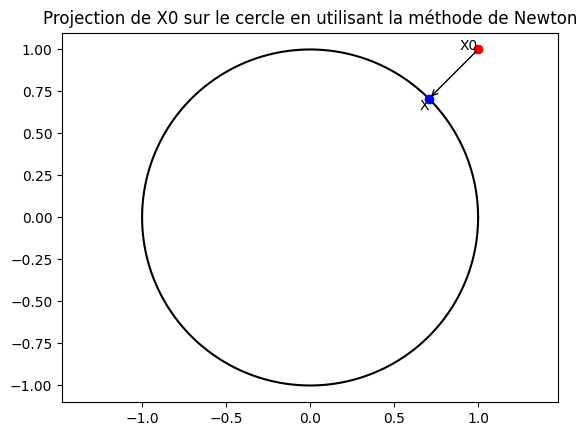

In [34]:
# Cas test simple
f_ = lambda X: np.sum(X**2) - 1
X0 = np.array([1, 1])
print("X0 = ", X0)

lamb = Newton(f_, X0[None, :]).ravel()
X = X0 + lamb * grad(f_, X0).T.ravel()

print("\nlamb = ", lamb)
print("X = ", X)
print("f(X) = ", f_(X))

# Vérification graphique

# Tracé de la fonction
theta = np.linspace(0, 2*np.pi, 400)
x_ = np.cos(theta)
y_ = np.sin(theta)
plt.plot(x_, y_, 'k')

# Tracé des points et de la flèche
plt.plot(X0[0], X0[1], 'ro')
plt.plot(X[0], X[1], 'bo')
plt.annotate('', xy=X, xytext=X0, arrowprops=dict(arrowstyle='->'))
plt.text(X0[0], X0[1], 'X0', ha='right')
plt.text(X[0], X[1], 'X', va='top', ha='right')
plt.axis('equal')
plt.title("Projection de X0 sur le cercle en utilisant la méthode de Newton")

## Déplacement des points

1. Pour chaque sommet, sommer les forces issues des sommets auxquels il est relié par une arête.

2. Appliquer à chaque sommet un déplacement égal à sa force cumulée multipliée par un paramètre $\delta t = 0.2$. On notera (avec des abus de notations)

    $$ X_i^{n+1} = X_i^n + \delta t F_i$$

    la position du sommet numéro $i$ à l'étape $n+1$ de l'algorithme, en fonction de la force $F_i$ qu'il reçoit.

3. Repérer les points qui sortent du domaine et les reprojeter sur le bord grâce à la méthode de Newton.

4. Retrianguler le nuage de points nouvellement obtenu et tracer le maillage courant.

5. Réitérer la procédure jusqu'à convergence.

In [35]:
# 1.
forces = vects * forces_intensities[:, None]
# print(forces)
vertices_forces = np.array([- np.sum(forces[(edges[:, 0] == vertice)]) + np.sum(forces[(edges[:, 1] == vertice)], axis=0) for vertice in range(len(grid_filter))])
# print(vertices_forces)

In [36]:
# 2.
delta = 2
new_points = grid_filter + delta * vertices_forces
# print(new_points)

Text(0.5, 1.0, 'Triangulation de Delaunay avec les points précédents')

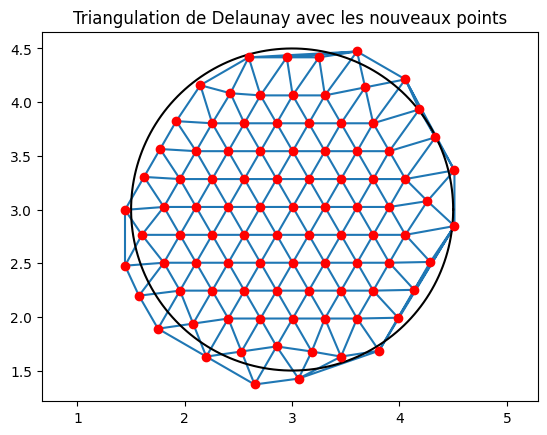

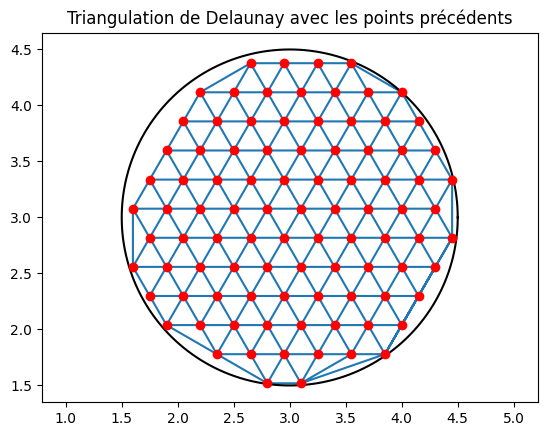

In [37]:
# Tracé du nouveau maillage

# Tracé du cercle (boite englobante)
# theta = np.linspace(0, 2*np.pi, 400)
# x = x0 + r*np.cos(theta)
# y = y0 + r*np.sin(theta)
# We reuse previous evaluated values of f
plt.plot(x, y, 'k')

# Tracé du nouveau maillage
new_tri = Delaunay(new_points)
plt.plot(new_points[:, 0], new_points[:, 1], "ro")
plt.triplot(new_points[:, 0], new_points[:, 1], new_tri.simplices)
plt.axis("equal")
plt.title("Triangulation de Delaunay avec les nouveaux points")

# Cas de base
plt.figure()
# Tracé du cercle (boite englobante)
plt.plot(x, y, 'k')

plt.plot(grid_filter[:, 0], grid_filter[:, 1], "ro")
plt.triplot(grid_filter[:, 0], grid_filter[:, 1], tri_prev.simplices)
plt.axis("equal")
plt.title("Triangulation de Delaunay avec les points précédents")

Text(0.5, 1.0, 'Projection des points extérieurs et retriangulation')

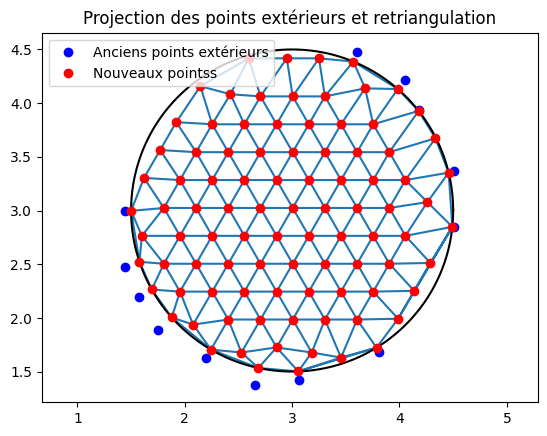

In [38]:
# Projection des points extérieurs et retriangulation
mask = f(new_points) > 0

lambs = Newton(f, new_points[mask])

old = new_points[mask].copy()
new_points[mask] += lambs * grad(f, new_points[mask])

plt.plot(x, y, 'k')

# Tracé du nouveau maillage
new_tri = Delaunay(new_points)
plt.plot(old[:, 0], old[:, 1], "bo", label="Anciens points extérieurs")
plt.plot(new_points[:, 0], new_points[:, 1], "ro", label="Nouveaux pointss")
plt.triplot(new_points[:, 0], new_points[:, 1], new_tri.simplices)
plt.axis("equal")
plt.legend()
plt.title("Projection des points extérieurs et retriangulation")

100%|██████████| 30/30 [00:00<00:00, 155.89it/s]


Text(0.5, 1.0, 'Maillage final')

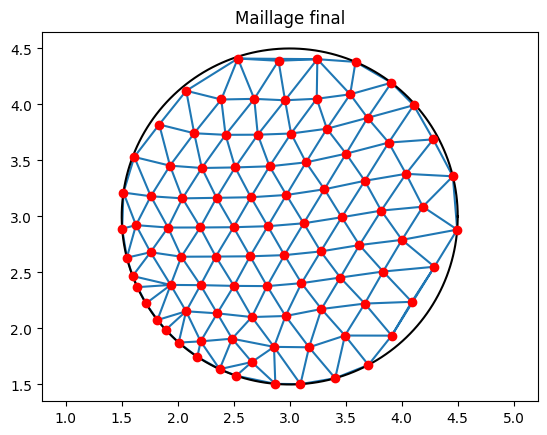

In [39]:
# Itération jusqu'à convergence

def expand(points, coef=1.2, delta=0.2):
    tri = Delaunay(points)
    simplices = tri.simplices

    # On construit les aretes
    edges = np.vstack([simplices[:, [0, 1]], simplices[:, [1, 2]], simplices[:, [2, 0]]])
    edges = np.sort(edges, axis=1)
    edges = np.unique(edges, axis=0)

    # Construction des vecteurs unitaires et de L0
    vects = points[edges[:, 1]] - points[edges[:, 0]]
    L = np.linalg.norm(vects, axis=1)
    vects_norm = vects / L[:, None]
    L0 = coef * np.sqrt(np.mean(L**2))

    # Determination et application des forces
    forces_intensities = np.maximum(L0-L, 0.0)
    forces = vects * forces_intensities[:, None]
    points_forces = np.array([- np.sum(forces[(edges[:, 0] == vertice)]) + np.sum(forces[(edges[:, 1] == vertice)], axis=0) for vertice in range(len(points))])
    points = points + delta * points_forces

    return points

def contract(points, f):
    mask = f(points) > 0
    lambs = Newton(f, points[mask])
    points[mask] += lambs * grad(f, points[mask])

    return points

n_iter = 30
coef = 1.2
delta = 0.2
points = grid_filter # On recommence par le maillage initial filtré

for _ in tqdm(range(n_iter)):
    points = expand(points, coef, delta)
    points = contract(points, f)

plt.plot(x, y, 'k') # Tracé du cercle (boite englobante)

# Tracé du maillage final
final_tri = Delaunay(points)
plt.plot(points[:, 0], points[:, 1], "ro", label="Points finaux")
plt.triplot(points[:, 0], points[:, 1], final_tri.simplices)
plt.axis("equal")
plt.title("Maillage final")

# Pour aller plus loin

Améliorer les maillages construits par le code que l'on vient d'écrire en :
1. Supprimant les points trop proches :
    Si la longueur d'une arêtes descend sous la tolérance $\delta$, fusionner les deux points qui compose cette arête pour en former un seul à mi-distance.

2. Considérant des domaînes non-convexes :
    Faire une procédure qui supprime les triangles à l'extérieur du domaine (la fonction Delaunay maille en effet l'enveloppe convexe des points fournis).
    
3. Adaptant localement le pas du maillage :
    Faire varier la longueur idéal $L_0$ en fonction de la position dans le domaine (pour faire du raffinement local de maillage).
    
4. Étendant la méthode en 3D :
    Construire un mailleur en tétraèdres en 3D. Qu'est-ce qui change par rapport aux idées évoquées ici?

100%|██████████| 100/100 [00:01<00:00, 87.07it/s]


Text(0.5, 1.0, 'Maillage final')

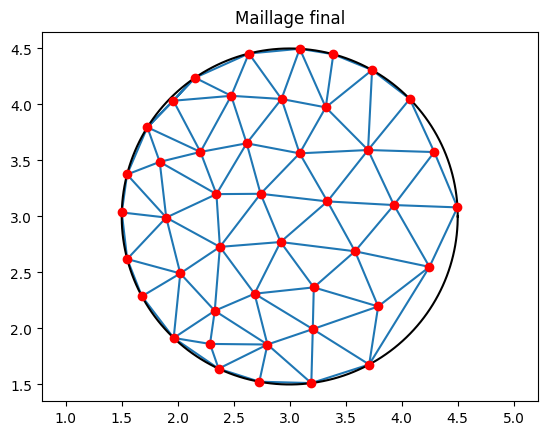

In [49]:
# Gestion des points proches

def rm_close_pts(points, delta=0.2):
    # Retourne les points ajustés
    tri = Delaunay(points)
    simplices = tri.simplices

    # On construit les aretes
    edges = np.vstack([simplices[:, [0, 1]], simplices[:, [1, 2]], simplices[:, [2, 0]]])
    edges = np.sort(edges, axis=1)
    edges = np.unique(edges, axis=0)

    vects = points[edges[:, 1]] - points[edges[:, 0]]
    L = np.linalg.norm(vects, axis=1)

    mask = L < delta
    for edge in edges[mask]:
        pt1_ind, pt2_ind = edge
        pt1 = points[pt1_ind]
        pt2 = points[pt2_ind]
        points[pt1_ind] = 0.5 * (pt1 + pt2)
        points[pt2_ind] = np.nan

    return points[~np.isnan(points).any(axis=1)].copy()

# Simulation à nouveau
n_iter = 100
coef = 1.2
delta = 0.2
points = grid_filter # On recommence par le maillage initial filtré

for _ in tqdm(range(n_iter)):
    # print(points)
    points = expand(points, coef, delta)
    points = contract(points, f)
    points = rm_close_pts(points, delta)
    # print("**", points.shape)

plt.plot(x, y, 'k') # Tracé du cercle (boite englobante)

# Tracé du maillage final
final_tri = Delaunay(points)
plt.plot(points[:, 0], points[:, 1], "ro", label="Points finaux")
plt.triplot(points[:, 0], points[:, 1], final_tri.simplices)
plt.axis("equal")
plt.title("Maillage final")